In [4]:
!pip install mne numpy scipy statsmodels torch numpy pandas matplotlib networkx


Defaulting to user installation because normal site-packages is not writeable


Exploratory - take 1 subject, 1 session, see it's plots of GC across

- 4 time windows
  
  - -> 200 data at a time

For each, Plot the frequency histogram of links in descending order.

In [5]:
import numpy as np
import mne
from statsmodels.tsa.stattools import grangercausalitytests
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the file paths
edf_file = "./Dataset/Infants_data/sub-NORB00001_ses-1_task-EEG_eeg.edf"

# Load the EEG data
raw = mne.io.read_raw_edf(edf_file, preload=True)

# Set the parameters for the sliding window
window_size = int(raw.info['sfreq'])  # 1.0  second window
overlap = int(0.25 * raw.info['sfreq'])  # 0.25  second overlap
step_size = window_size - overlap

# Get the data from the Raw object
data = raw.get_data()

# Number of channels (nodes)
n_channels = data.shape[0]

# Initialize a cumulative adjacency matrix for the entire time series
total_adj_matrix = np.zeros((n_channels, n_channels))

# Initialize list to store adjacency matrices for each window
adj_matrices = []

# Loop through the data with the sliding window
for start in range(0, data.shape[1] - window_size, step_size):
    end = start + window_size
    window_data = data[:, start:end]

    # Initialize an empty adjacency matrix for the current window
    adj_matrix = np.zeros((n_channels, n_channels))

    # Compute Granger causality between each pair of channels
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                # Prepare the data for Granger causality test
                X = np.vstack([window_data[i, :], window_data[j, :]]).T
                try:
                    result = grangercausalitytests(X, maxlag=1, verbose=False)
                    p_value = result[1][0]['ssr_ftest'][1]
                    if p_value < 0.05:  # If p-value is significant
                        adj_matrix[i, j] = 1
                        total_adj_matrix[i, j] += 1
                except np.linalg.LinAlgError:
                    continue

    # Store the adjacency matrix for this time window
    adj_matrices.append(adj_matrix)




Extracting EDF parameters from /home/alookaladdoo/CNS_Summer_Project_1/Code/Dataset/Infants_data/sub-NORB00001_ses-1_task-EEG_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 142799  =      0.000 ...   713.995 secs...


/home/alookaladdoo/.local/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


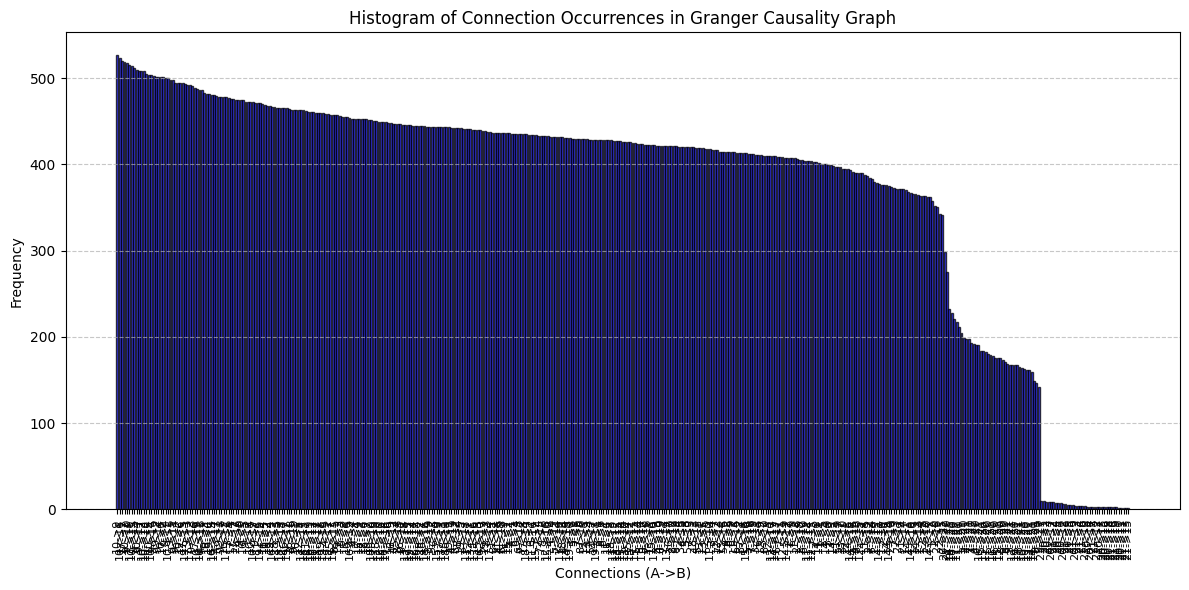

In [6]:
# Create a dictionary to map connections to their counts
connection_counts = {}
for i in range(n_channels):
    for j in range(n_channels):
        if total_adj_matrix[i, j] > 0:  # Only include non-zero connections
            connection_counts[f"{i+1}->{j+1}"] = total_adj_matrix[i, j]

# Sort the connections by their count (optional)
sorted_connections = sorted(connection_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the labels and counts
x_labels = [conn[0] for conn in sorted_connections]
y_values = [conn[1] for conn in sorted_connections]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(x_labels, y_values, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Connection Occurrences in Granger Causality Graph')
plt.xlabel('Connections (A->B)')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to fit x-axis labels
plt.show()

In [7]:
# Print the top 10 connections
print("Top 10 connections:")
for idx, (connection, count) in enumerate(sorted_connections[:10], start=1):
    print(f"{idx}. {connection}: {count} occurrences")

Top 10 connections:
1. 10->9: 527.0 occurrences
2. 10->16: 523.0 occurrences
3. 17->1: 520.0 occurrences
4. 10->7: 519.0 occurrences
5. 9->10: 518.0 occurrences
6. 17->18: 515.0 occurrences
7. 10->15: 514.0 occurrences
8. 9->15: 512.0 occurrences
9. 10->4: 510.0 occurrences
10. 9->17: 509.0 occurrences


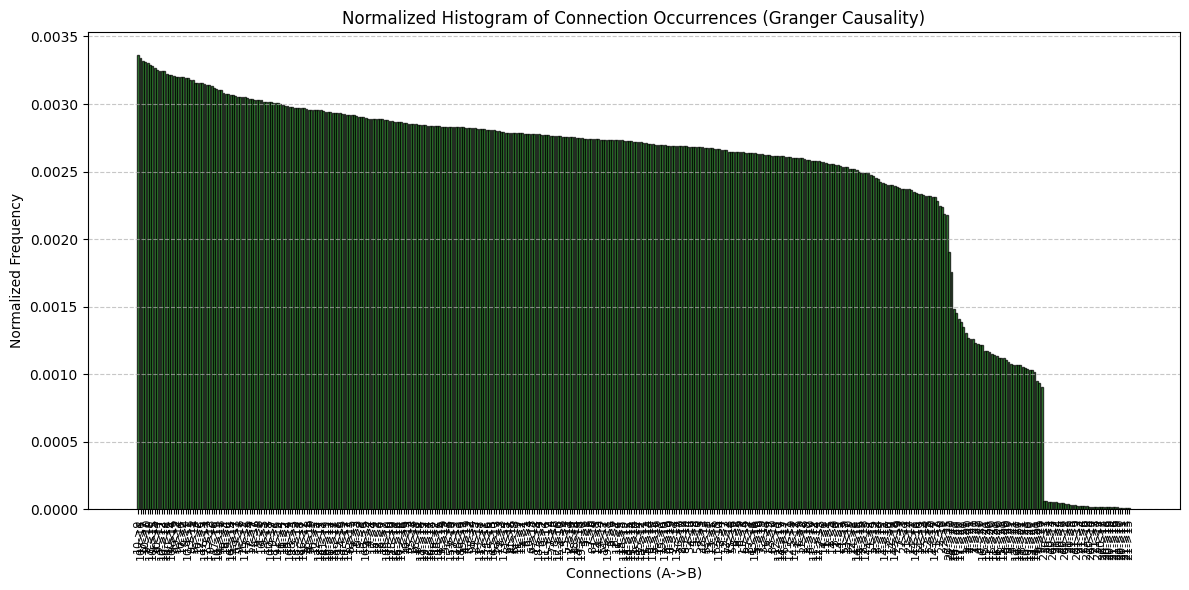

Top 10 connections by normalized frequency:
1. 10->9: 0.0034 (relative frequency)
2. 10->16: 0.0033 (relative frequency)
3. 17->1: 0.0033 (relative frequency)
4. 10->7: 0.0033 (relative frequency)
5. 9->10: 0.0033 (relative frequency)
6. 17->18: 0.0033 (relative frequency)
7. 10->15: 0.0033 (relative frequency)
8. 9->15: 0.0033 (relative frequency)
9. 10->4: 0.0033 (relative frequency)
10. 9->17: 0.0032 (relative frequency)


In [8]:
# Calculate the total number of connections
total_connections = sum(connection_counts.values())

# Normalize the counts by dividing by the total number of connections
normalized_counts = {conn: count / total_connections for conn, count in connection_counts.items()}

# Sort the connections by normalized counts
sorted_normalized_connections = sorted(normalized_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the labels and normalized values
x_labels_normalized = [conn[0] for conn in sorted_normalized_connections]
y_values_normalized = [conn[1] for conn in sorted_normalized_connections]

# Plot the normalized histogram
plt.figure(figsize=(12, 6))
plt.bar(x_labels_normalized, y_values_normalized, alpha=0.75, color='green', edgecolor='black')
plt.title('Normalized Histogram of Connection Occurrences (Granger Causality)')
plt.xlabel('Connections (A->B)')
plt.ylabel('Normalized Frequency')
plt.xticks(rotation=90, fontsize=8)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to fit x-axis labels
plt.show()

# Print the top 10 connections by normalized frequency
print("Top 10 connections by normalized frequency:")
for idx, (connection, norm_freq) in enumerate(sorted_normalized_connections[:10], start=1):
    print(f"{idx}. {connection}: {norm_freq:.4f} (relative frequency)")


Top 10 nodes by normalized out-degree:
1. Node 10: 0.0595 (normalized)
2. Node 9: 0.0583 (normalized)
3. Node 17: 0.0565 (normalized)
4. Node 16: 0.0552 (normalized)
5. Node 18: 0.0548 (normalized)
6. Node 19: 0.0548 (normalized)
7. Node 4: 0.0532 (normalized)
8. Node 15: 0.0525 (normalized)
9. Node 11: 0.0519 (normalized)
10. Node 12: 0.0518 (normalized)


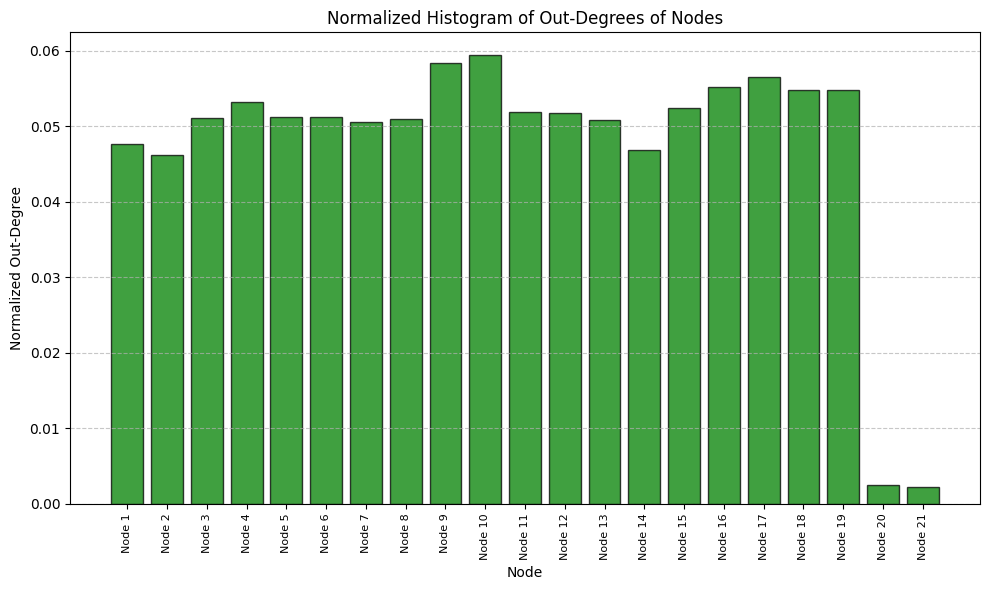

In [9]:
# Calculate out-degrees for each node
out_degrees = np.sum(total_adj_matrix, axis=1)  # Sum across rows to get out-degree for each node

# Calculate the total number of connections
total_connections = np.sum(out_degrees)

# Normalize out-degrees by the total number of connections
normalized_out_degrees = out_degrees / total_connections

# Print the top 10 nodes with the highest normalized out-degrees
sorted_normalized_out_degrees = sorted(enumerate(normalized_out_degrees, start=1), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by normalized out-degree:")
for idx, (node, norm_out_degree) in enumerate(sorted_normalized_out_degrees[:10], start=1):
    print(f"{idx}. Node {node}: {norm_out_degree:.4f} (normalized)")

# Plot the normalized histogram of out-degrees
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_channels + 1), normalized_out_degrees, alpha=0.75, color='green', edgecolor='black')
plt.title('Normalized Histogram of Out-Degrees of Nodes')
plt.xlabel('Node')
plt.ylabel('Normalized Out-Degree')
plt.xticks(range(1, n_channels + 1), [f"Node {i}" for i in range(1, n_channels + 1)], rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


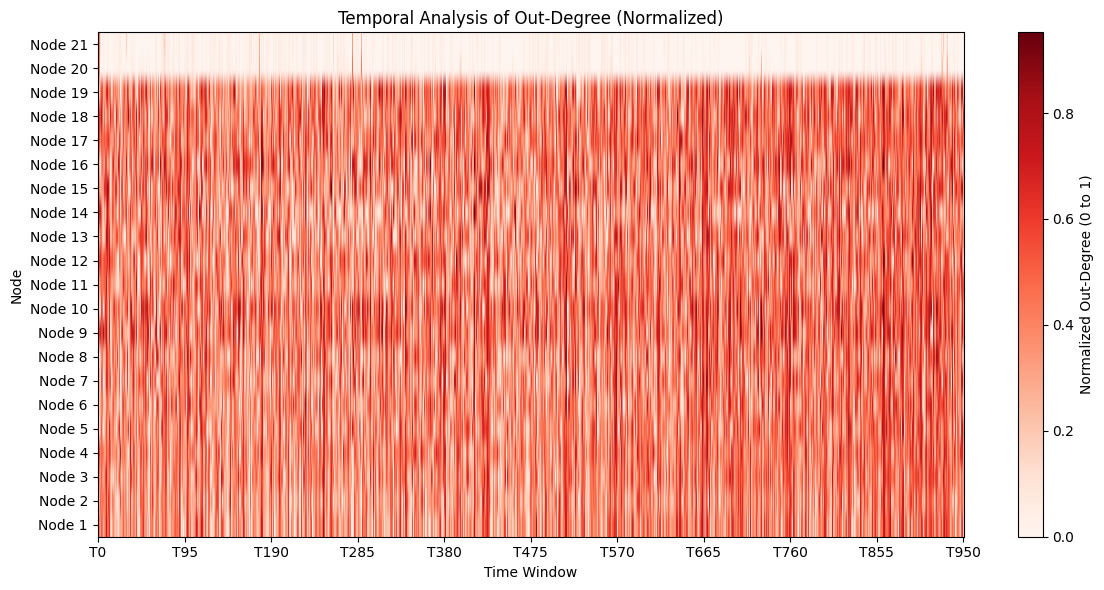

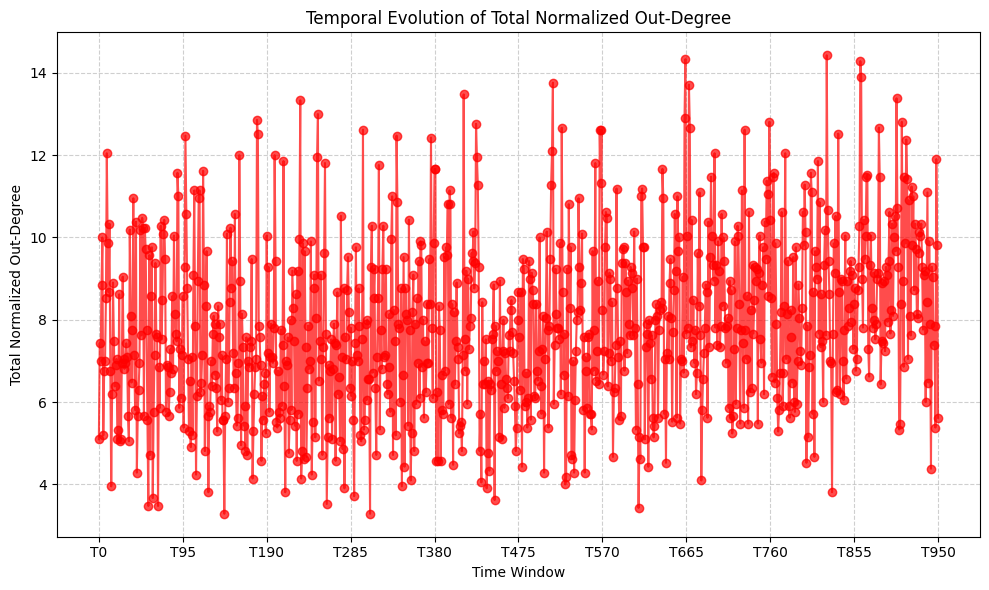

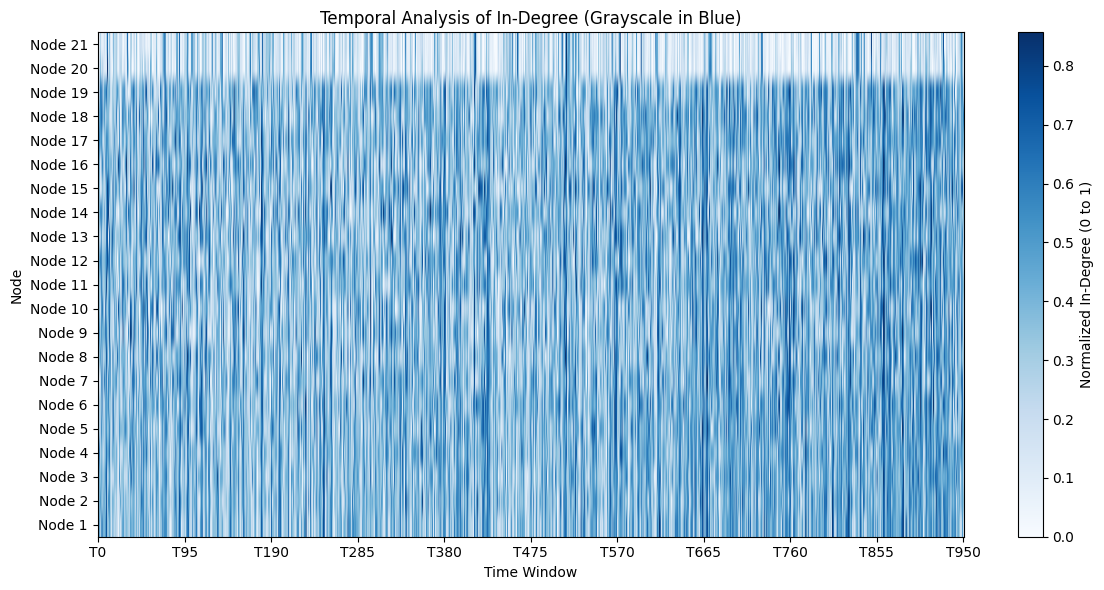

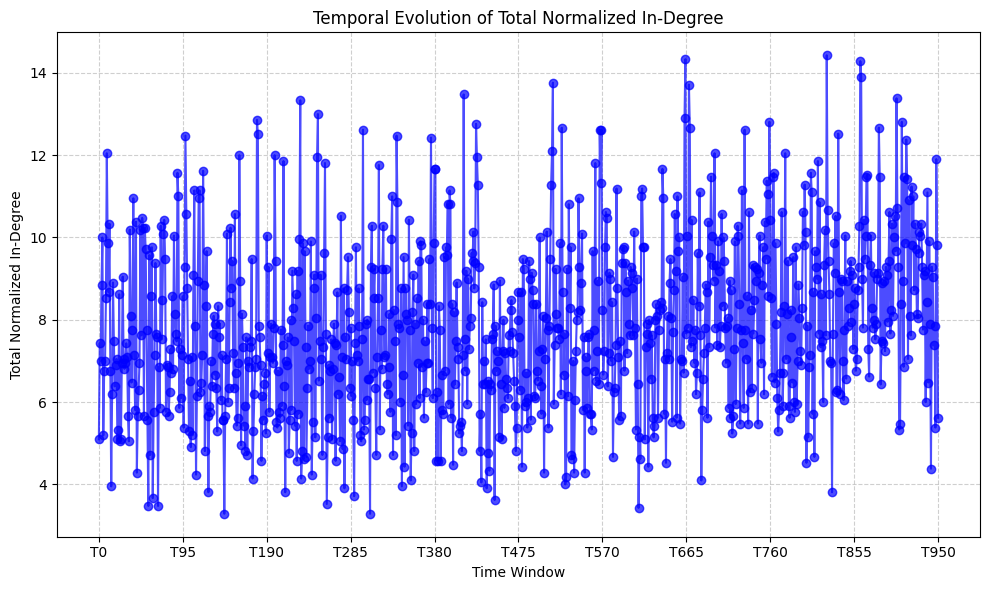

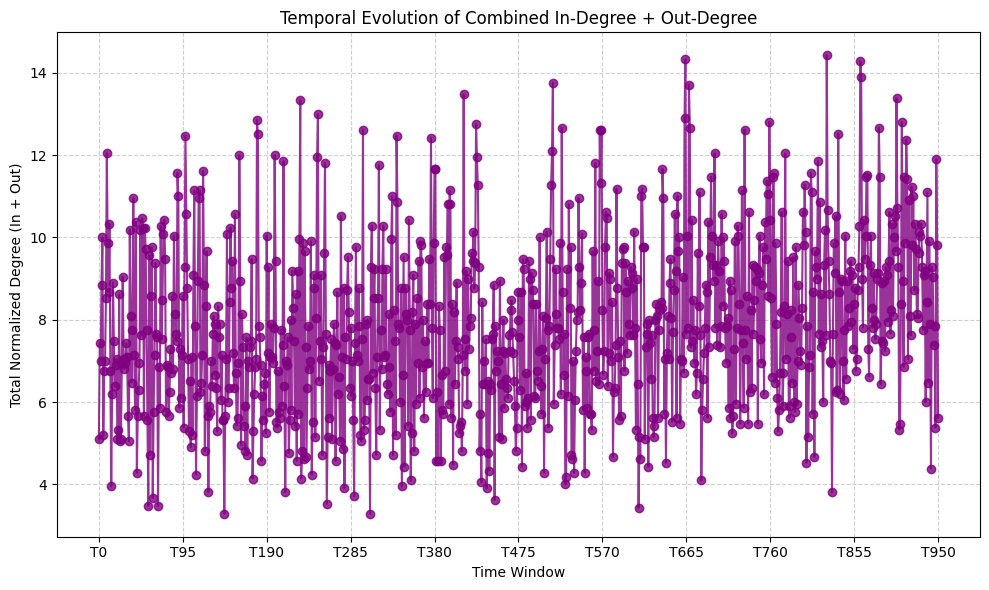

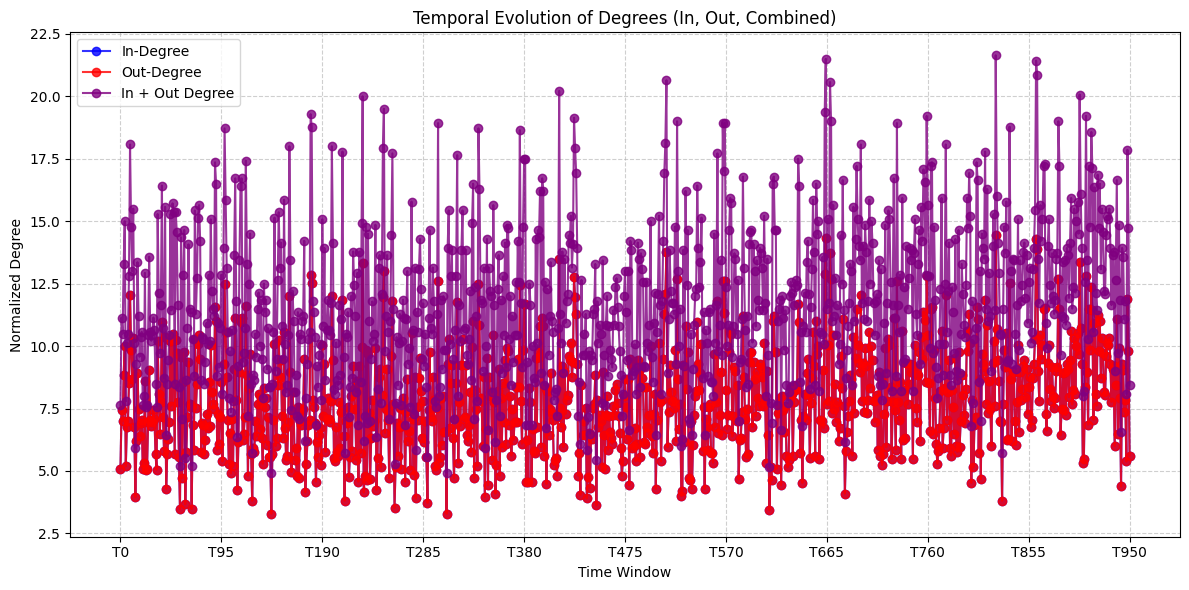

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Number of nodes
n_nodes = len(adj_matrices[0])

# Number of time windows
n_time_windows = len(adj_matrices)

# Initialize a matrix to store normalized out-degrees
out_degree_matrix = np.zeros((n_nodes, n_time_windows))

# Calculate normalized out-degrees for each time window
for t, adj_matrix in enumerate(adj_matrices):
    out_degrees = np.sum(adj_matrix, axis=1)  # Sum across rows to get out-degrees
    normalized_out_degrees = out_degrees / n_nodes  # Normalize by the number of nodes
    out_degree_matrix[:, t] = normalized_out_degrees

# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(out_degree_matrix, aspect='auto', cmap='Reds', origin='lower')
plt.colorbar(label='Normalized Out-Degree (0 to 1)')
plt.title('Temporal Analysis of Out-Degree (Normalized)')
plt.xlabel('Time Window')
plt.ylabel('Node')
plt.xticks(ticks=np.arange(0, n_time_windows, step=max(1, n_time_windows // 10)),
           labels=[f"T{i}" for i in range(0, n_time_windows, max(1, n_time_windows // 10))])
plt.yticks(ticks=np.arange(n_nodes), labels=[f"Node {i+1}" for i in range(n_nodes)])
plt.tight_layout()
plt.show()

# Number of nodes
n_nodes = len(adj_matrices[0])

# Number of time windows
n_time_windows = len(adj_matrices)

# Initialize a list to store the total normalized out-degree for each time window
collapsed_out_degree = []

# Calculate total normalized out-degree for each time window
for adj_matrix in adj_matrices:
    out_degrees = np.sum(adj_matrix, axis=1)  # Sum across rows to get out-degrees
    total_out_degree = np.sum(out_degrees) / n_nodes  # Normalize by the number of nodes
    collapsed_out_degree.append(total_out_degree)

# Plot the time-series of total normalized out-degree
plt.figure(figsize=(10, 6))
plt.plot(range(n_time_windows), collapsed_out_degree, marker='o', linestyle='-', color='red', alpha=0.7)
plt.title('Temporal Evolution of Total Normalized Out-Degree')
plt.xlabel('Time Window')
plt.ylabel('Total Normalized Out-Degree')
plt.xticks(ticks=np.arange(0, n_time_windows, step=max(1, n_time_windows // 10)),
           labels=[f"T{i}" for i in range(0, n_time_windows, max(1, n_time_windows // 10))])
plt.grid(alpha=0.6, linestyle='--')
plt.tight_layout()
plt.show()


# Number of nodes
n_nodes = len(adj_matrices[0])

# Number of time windows
n_time_windows = len(adj_matrices)

# Initialize a matrix to store normalized in-degrees
in_degree_matrix = np.zeros((n_nodes, n_time_windows))

# Calculate normalized in-degrees for each time window
for t, adj_matrix in enumerate(adj_matrices):
    in_degrees = np.sum(adj_matrix, axis=0)  # Sum across columns to get in-degrees
    normalized_in_degrees = in_degrees / n_nodes  # Normalize by the number of nodes
    in_degree_matrix[:, t] = normalized_in_degrees

# Plot the heatmap with 'Blues' colormap
plt.figure(figsize=(12, 6))
plt.imshow(in_degree_matrix, aspect='auto', cmap='Blues', origin='lower')
plt.colorbar(label='Normalized In-Degree (0 to 1)')
plt.title('Temporal Analysis of In-Degree (Grayscale in Blue)')
plt.xlabel('Time Window')
plt.ylabel('Node')
plt.xticks(ticks=np.arange(0, n_time_windows, step=max(1, n_time_windows // 10)),
           labels=[f"T{i}" for i in range(0, n_time_windows, max(1, n_time_windows // 10))])
plt.yticks(ticks=np.arange(n_nodes), labels=[f"Node {i+1}" for i in range(n_nodes)])
plt.tight_layout()
plt.show()

# Number of nodes
n_nodes = len(adj_matrices[0])

# Number of time windows
n_time_windows = len(adj_matrices)

# Initialize a list to store the total normalized in-degree for each time window
collapsed_in_degree = []

# Calculate total normalized in-degree for each time window
for adj_matrix in adj_matrices:
    in_degrees = np.sum(adj_matrix, axis=0)  # Sum across columns to get in-degrees
    total_in_degree = np.sum(in_degrees) / n_nodes  # Normalize by the number of nodes
    collapsed_in_degree.append(total_in_degree)

# Plot the time-series of total normalized in-degree
plt.figure(figsize=(10, 6))
plt.plot(range(n_time_windows), collapsed_in_degree, marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title('Temporal Evolution of Total Normalized In-Degree')
plt.xlabel('Time Window')
plt.ylabel('Total Normalized In-Degree')
plt.xticks(ticks=np.arange(0, n_time_windows, step=max(1, n_time_windows // 10)),
           labels=[f"T{i}" for i in range(0, n_time_windows, max(1, n_time_windows // 10))])
plt.grid(alpha=0.6, linestyle='--')
plt.tight_layout()
plt.show()

# Number of nodes
n_nodes = len(adj_matrices[0])

# Number of time windows
n_time_windows = len(adj_matrices)

# Initialize lists to store total normalized in-degree and out-degree
collapsed_in_degree = []
collapsed_out_degree = []

# Calculate total normalized in-degree and out-degree for each time window
for adj_matrix in adj_matrices:
    in_degrees = np.sum(adj_matrix, axis=0)  # Sum across columns for in-degrees
    out_degrees = np.sum(adj_matrix, axis=1)  # Sum across rows for out-degrees
    total_in_degree = np.sum(in_degrees) / n_nodes /2 # Normalize in-degrees
    total_out_degree = np.sum(out_degrees) / n_nodes /2  # Normalize out-degrees
    collapsed_in_degree.append(total_in_degree)
    collapsed_out_degree.append(total_out_degree)

# Calculate the combined degree (in-degree + out-degree)
combined_degree = [in_d + out_d for in_d, out_d in zip(collapsed_in_degree, collapsed_out_degree)]

# Plot the time-series of combined degree
plt.figure(figsize=(10, 6))
plt.plot(range(n_time_windows), combined_degree, marker='o', linestyle='-', color='purple', alpha=0.8)
plt.title('Temporal Evolution of Combined In-Degree + Out-Degree')
plt.xlabel('Time Window')
plt.ylabel('Total Normalized Degree (In + Out)')
plt.xticks(ticks=np.arange(0, n_time_windows, step=max(1, n_time_windows // 10)),
           labels=[f"T{i}" for i in range(0, n_time_windows, max(1, n_time_windows // 10))])
plt.grid(alpha=0.6, linestyle='--')
plt.tight_layout()
plt.show()

# Number of nodes
n_nodes = len(adj_matrices[0])

# Number of time windows
n_time_windows = len(adj_matrices)

# Initialize lists to store total normalized in-degree and out-degree
collapsed_in_degree = []
collapsed_out_degree = []

# Calculate total normalized in-degree and out-degree for each time window
for adj_matrix in adj_matrices:
    in_degrees = np.sum(adj_matrix, axis=0)  # Sum across columns for in-degrees
    out_degrees = np.sum(adj_matrix, axis=1)  # Sum across rows for out-degrees
    total_in_degree = np.sum(in_degrees) / n_nodes  # Normalize in-degrees
    total_out_degree = np.sum(out_degrees) / n_nodes  # Normalize out-degrees
    collapsed_in_degree.append(total_in_degree)
    collapsed_out_degree.append(total_out_degree)

# Calculate the combined degree (in-degree + out-degree)
combined_degree = [in_d + out_d / 2 for in_d, out_d in zip(collapsed_in_degree, collapsed_out_degree)]

# Plot all three time-series
plt.figure(figsize=(12, 6))
plt.plot(range(n_time_windows), collapsed_in_degree, marker='o', linestyle='-', color='blue', label='In-Degree', alpha=0.8)
plt.plot(range(n_time_windows), collapsed_out_degree, marker='o', linestyle='-', color='red', label='Out-Degree', alpha=0.8)
plt.plot(range(n_time_windows), combined_degree, marker='o', linestyle='-', color='purple', label='In + Out Degree', alpha=0.8)

# Customize plot
plt.title('Temporal Evolution of Degrees (In, Out, Combined)')
plt.xlabel('Time Window')
plt.ylabel('Normalized Degree')
plt.xticks(ticks=np.arange(0, n_time_windows, step=max(1, n_time_windows // 10)),
           labels=[f"T{i}" for i in range(0, n_time_windows, max(1, n_time_windows // 10))])
plt.grid(alpha=0.6, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Check if the adjacency matrices are symmetric
symmetric_matrices = []
for t, adj_matrix in enumerate(adj_matrices):
    is_symmetric = np.array_equal(adj_matrix, adj_matrix.T)
    symmetric_matrices.append(is_symmetric)
    print(f"Time Window {t}: {'Symmetric' if is_symmetric else 'Not Symmetric'}")

# Summary of results
num_symmetric = sum(symmetric_matrices)
num_total = len(adj_matrices)
print(f"\nOut of {num_total} time windows, {num_symmetric} have symmetric adjacency matrices.")


Time Window 0: Not Symmetric
Time Window 1: Not Symmetric
Time Window 2: Not Symmetric
Time Window 3: Not Symmetric
Time Window 4: Not Symmetric
Time Window 5: Not Symmetric
Time Window 6: Not Symmetric
Time Window 7: Not Symmetric
Time Window 8: Not Symmetric
Time Window 9: Not Symmetric
Time Window 10: Not Symmetric
Time Window 11: Not Symmetric
Time Window 12: Not Symmetric
Time Window 13: Not Symmetric
Time Window 14: Not Symmetric
Time Window 15: Not Symmetric
Time Window 16: Not Symmetric
Time Window 17: Not Symmetric
Time Window 18: Not Symmetric
Time Window 19: Not Symmetric
Time Window 20: Not Symmetric
Time Window 21: Not Symmetric
Time Window 22: Not Symmetric
Time Window 23: Not Symmetric
Time Window 24: Not Symmetric
Time Window 25: Not Symmetric
Time Window 26: Not Symmetric
Time Window 27: Not Symmetric
Time Window 28: Not Symmetric
Time Window 29: Not Symmetric
Time Window 30: Not Symmetric
Time Window 31: Not Symmetric
Time Window 32: Not Symmetric
Time Window 33: Not 